## `LMD-matched` Data Exploration
Our dataset consists of: 
* `lmd_matched_h5`: Contains HDF5 files with MSD data (song name, artist name, metadata, etc.)
* `lmd_matched`: Contains MIDI files (sometimes more than 1 per MSD entry) matched with the MSD ids from `lmd_matched_h5`
* `match_scores.json`: File with match scores of the MSD entries and the MIDIs that correspond with them. 

In [90]:
 # Imports
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi
import librosa
import tables
import os
import json
import h5py

# Local path constants
DATA_PATH = '../data'
SCORE_FILE = os.path.join(DATA_PATH, 'match_scores.json')

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def msd_id_to_h5(msd_id):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(DATA_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

def get_midi_path(msd_id, midi_md5, kind):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file.
    kind should be one of 'matched' or 'aligned'. """
    return os.path.join(DATA_PATH, 'lmd_{}'.format(kind),
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

In [158]:
# Get list of h5_ids
metadata_folder = '../data/lmd_matched_h5/'
h5_ids = []

subdirs = [sub for sub in os.listdir(metadata_folder) if sub[0] != '.']
for subdir in subdirs:
    subsubdirs = [sub for sub in os.listdir(metadata_folder + subdir) if sub[0] != '.']
    for subsubdir in subsubdirs:
        subsubsubdirs = [sub for sub in os.listdir(metadata_folder + subdir + '/' + subsubdir) if sub[0] != '.']
        for subsubsubdir in subsubsubdirs:
            data_files = os.listdir(metadata_folder + subdir + '/' + subsubdir + '/' + subsubsubdir)
            for df in data_files: 
                cur_file = metadata_folder + subdir + '/' + subsubdir + '/' + subsubsubdir + '/' + df
                h5_paths.append(cur_file)
                h5_ids.append(df[:-3])

print("IDS:", len(h5_ids), h5_ids[:4])

IDS: 31034 ['TRRRUFD12903CD7092', 'TRRRUTV12903CEA11B', 'TRRRUJO128E07813E7', 'TRRRIYO128F428CF6F']


### What's inside an HDF5 file? 
Once we load in an file with `h5py.File(path,'r')`, how do we access its contents? 

Each H5 object is a dictionary with three keys: `analysis`, `metadata`, and `musicbrainz`. We mostly care about the `metadata` dictionary. 
* To get the song title and artist name: `f['metadata']['songs']['title'][0], f['metadata']['songs']['artist_name'][0]`
* We access the Echo Nest artist tags with `f['metadata']['artist_terms'][:]`.

In [144]:
f = h5py.File(msd_id_to_h5('TRRRUFD12903CD7092'), 'r')
print(f.keys())
print(f['analysis'].keys())
print(f['metadata'].keys())
print(f['musicbrainz'].keys())
print(f['metadata']['songs']['title'][0].decode('utf-8'), f['metadata']['songs']['artist_name'][0].decode('utf-8'))
artist_terms = [term.decode('utf-8') for term in f['metadata']['artist_terms'][:]]
musicbrainz_terms = [term.decode('utf-8') for term in f['musicbrainz']['artist_mbtags'][:]]
print(artist_terms)
print(musicbrainz_terms)

<KeysViewHDF5 ['analysis', 'metadata', 'musicbrainz']>
<KeysViewHDF5 ['bars_confidence', 'bars_start', 'beats_confidence', 'beats_start', 'sections_confidence', 'sections_start', 'segments_confidence', 'segments_loudness_max', 'segments_loudness_max_time', 'segments_loudness_start', 'segments_pitches', 'segments_start', 'segments_timbre', 'songs', 'tatums_confidence', 'tatums_start']>
<KeysViewHDF5 ['artist_terms', 'artist_terms_freq', 'artist_terms_weight', 'similar_artists', 'songs']>
<KeysViewHDF5 ['artist_mbtags', 'artist_mbtags_count', 'songs']>
Wastelands Hawkwind
['space rock', 'art rock', 'heavy metal', 'hard rock', 'rock', 'progressive', 'psychedelic', 'england', 'progressive rock', 'psychedelic rock', 'guitar', 'electronic', 'metal', 'drums', 'instrumental', 'alternative', 'drone', 'funky', 'original', 'lyrics', 'noise', 'stoner', 'jam', 'haunting']
['british', 'hard rock', 'psychedelic rock', 'rock', 'progressive rock', 'uk', 'english', 'space rock', 'classic pop and rock']


In [143]:
# get names of dataset fields
print(f['metadata']['songs'].dtype.fields.keys())
print(f['metadata']['songs']['artist_name'][0].decode('utf-8'))

dict_keys(['analyzer_version', 'artist_7digitalid', 'artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_mbid', 'artist_name', 'artist_playmeid', 'genre', 'idx_artist_terms', 'idx_similar_artists', 'release', 'release_7digitalid', 'song_hotttnesss', 'song_id', 'title', 'track_7digitalid'])
A Balladeer


In [145]:
genre_tag_counts = {}
artist_counts = {}
num_artist_tags = {}

for h_id in h5_ids:
    f = h5py.File(msd_id_to_h5(h_id), 'r')
    terms = [term.decode('utf-8') for term in f['metadata']['artist_terms'][:]]
    artist_name = f['metadata']['songs']['artist_name'][0].decode('utf-8')
    for t in terms: 
        if t in genre_tag_counts.keys():
            genre_tag_counts[t] += 1
        else: 
            genre_tag_counts[t] = 1
    if artist_name in artist_counts.keys():
        artist_counts[artist_name] += 1
    else: 
        artist_counts[artist_name] = 1
        num_artist_tags[artist_name] = len(terms)

In [146]:
print(len(genre_tag_counts.keys()), len(artist_counts.keys()))
tags_by_freq = {k: v for k, v in sorted(genre_tag_counts.items(), reverse=True, key=lambda item: item[1])}
artists_by_freq = {k: v for k, v in sorted(artist_counts.items(), reverse=True, key=lambda item: item[1])}

for i in range(10):
    cur_key = list(tags_by_freq.keys())[i]
    print(cur_key, tags_by_freq[cur_key])

for i in range(10):
    cur_key = list(artists_by_freq.keys())[i]
    print(cur_key, artists_by_freq[cur_key])


4675 11483
rock 22846
pop 22548
electronic 17167
pop rock 11864
jazz 11403
alternative rock 9892
ballad 9823
hip hop 9816
soul 9607
disco 9572
Panpipes 102
The Cranberries 73
Mariah Carey 57
Abba 56
Richard Clayderman 55
Mariano Yanani 52
Scott Joplin 51
Creedence Clearwater Revival 49
Green Day 49
Céline Dion 49


In [126]:
for i in range(20):
    cur_key = list(tags_by_freq.keys())[i]
    print(cur_key, tags_by_freq[cur_key])

rock 22846
pop 22548
electronic 17167
pop rock 11864
jazz 11403
alternative rock 9892
ballad 9823
hip hop 9816
soul 9607
disco 9572
vocal 8980
classic rock 8821
house 8772
alternative 8517
folk 8445
united states 8343
soundtrack 8059
soft rock 7827
country 7705
electro 7688


28.930157624314205


Text(0, 0.5, '# of artists')

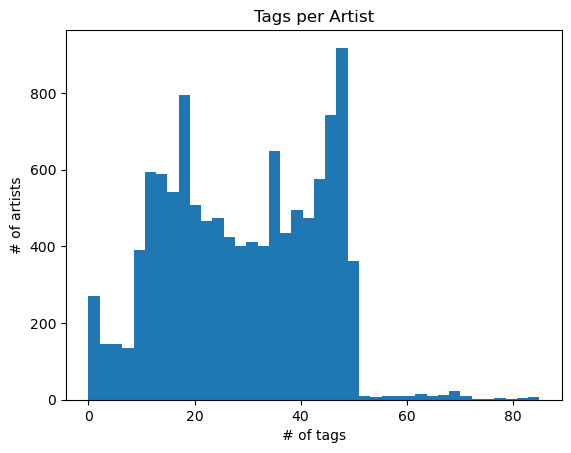

In [121]:
from statistics import mean
import matplotlib.pyplot as plt

num_tags = list(num_artist_tags.values())

print(mean(num_tags))

N_points = 100000
n_bins = 40

fig, axs = plt.subplots(1, 1) #, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs.hist(num_tags, bins=n_bins)
axs.set_title("Tags per Artist")
axs.set_xlabel("# of tags")
axs.set_ylabel("# of artists")

In [125]:
#print(genre_tag_counts.keys())
pop_subgenres = []
rock_subgenres = []
country_subgenres = []
metal_subgenres = [] 
jazz_subgenres = []
rap_subgenres = []
hiphop_subgenres = []
key_list = list(genre_tag_counts.keys())
for key in key_list:
    if 'pop' in key:
        print(key)
        pop_subgenres.append(key)
    if 'rock' in key:
        rock_subgenres.append(key)
    if 'country' in key:
        country_subgenres.append(key)
    if 'metal' in key:
        metal_subgenres.append(key) 
    if 'jazz' in key:
        jazz_subgenres.append(key)
    if 'rap' in key:
        rap_subgenres.append(key)
    if 'hip hop' in key:
        hiphop_subgenres.append(key)
print(len(pop_subgenres))
print(len(rock_subgenres))
print(len(country_subgenres))
print(len(metal_subgenres))
print(len(jazz_subgenres))
print(len(rap_subgenres))
print(len(hiphop_subgenres))

pop rock
german pop
pop
europop
chamber pop
british pop
synthpop
dance pop
indie pop
alternative pop rock
pop underground
reggae pop
instrumental pop
pop rap
j pop
vocal pop
dutch pop
am pop
spanish pop
latin pop
futurepop
pop punk
punk pop
power pop
traditional pop
cantonese pop
cpop
kpop
chinese pop
alternative pop
guitar pop
irish pop
french pop
psychedelic pop
pop metal
dream pop
sunshine pop
italian pop
pop folk
italian pop rock
bubblegum pop
pop en espanol
folk-pop
orchestral pop
space age pop
country pop
electropop
brazilian pop music
finnish pop
pop espanol
turkish pop
world pop
pop reggae
teen pop
jangle pop
noise pop
swedish pop
pop idol
00s pop
brill building pop
80s pop
pop country
jazz pop
emo pop
girl pop duo
mexican pop
90s pop
pop soul
hk-pop
twee pop
60s pop
afropop
sub pop records
sub pop bands
pops
classical pop
hip pop
melodic pop
spanish indie pop
spanish pop rock
pop independiente
contempopranea
bastard pop
indie pop rock
70s pop
suomipop
pop latino
melodic poppy 

100%|██████████| 191401/191401 [00:00<00:00, 1291905.54it/s]

{'Rock': 75013, 'Rap': 11001, 'Latin': 3113, 'Jazz': 14700, 'Electronic': 21865, 'Pop': 12967, 'Metal': 9224, 'RnB': 9811, 'Country': 8983, 'Reggae': 7970, 'Blues': 6219, 'Folk': 4188, 'Punk': 3275, 'World': 1919, 'New Age': 1153}
# of rock songs: 75013


In [201]:
from tqdm import tqdm
# Load in cls file:
cd2c_path = '/Users/sadiela/Documents/phd/research/music/genre_study/data/msd_tagtraum_cd2c.cls'
ms_ids = []
genres = []
unique_genres = {}
genre_separated_ids = {}

with open(cd2c_path, 'r') as f: 
    lines = f.readlines()

    for line in tqdm(lines):
        msid, genre = line.rstrip().split('\t')
        genre = "".join(genre.split()).lower()

        if genre not in unique_genres:
            unique_genres[genre] = 1 #.append(genre)
            genre_separated_ids[genre] = [msid]
        else: 
            unique_genres[genre] += 1
            genre_separated_ids[genre].append(msid)
     
        ms_ids.append(msid)
        genres.append(genre)

genre_names = list(unique_genres.keys())
print(unique_genres)
print("# of rock songs:", len(genre_separated_ids['rock']))

lmd_matched_genre_dict = {} 

for genre in genre_names:
    genre = "".join(genre.split()).lower()
    lmd_matched_genre_dict[genre] = [] 
    for msid in tqdm(genre_separated_ids[genre]):
        if msid in h5_ids:
            lmd_matched_genre_dict[genre].append(msid)
    print(genre, len(lmd_matched_genre_dict[genre]))

100%|██████████| 191401/191401 [00:00<00:00, 1099387.96it/s]


{'rock': 75013, 'rap': 11001, 'latin': 3113, 'jazz': 14700, 'electronic': 21865, 'pop': 12967, 'metal': 9224, 'rnb': 9811, 'country': 8983, 'reggae': 7970, 'blues': 6219, 'folk': 4188, 'punk': 3275, 'world': 1919, 'newage': 1153}
# of rock songs: 75013
rock 2437
rap 113
latin 105
jazz 213
electronic 465
pop 1472
metal 176
rnb 362
country 624
reggae 60
blues 25
folk 44
punk 13
world 15
newage 56


In [202]:
import yaml 

msid_path = '/Users/sadiela/Documents/phd/research/music/genre_study/data/genre_separated_ids.yaml'

with open(msid_path, 'w') as file: 
    yaml.dump(lmd_matched_genre_dict, file, default_flow_style=False)

### Pulling MIDI SNIPPETS

In [203]:
#print(SCORE_FILE)
import json

lmd_checksum_genre_dict = {}
 
# Opening JSON file
with open(SCORE_FILE) as json_file:
    match_scores = json.load(json_file)

genre_names = ["".join(genre.split()).lower() for genre in genre_names]

for genre in genre_names:
    lmd_checksum_genre_dict[genre] = {}
    msids = lmd_matched_genre_dict[genre]
    for msid in msids: 
        f = h5py.File(msd_id_to_h5(msid), 'r')
        artist_name = f['metadata']['songs']['artist_name'][0].decode('utf-8')
        song_name = f['metadata']['songs']['title'][0].decode('utf-8')
        popularity = f['metadata']['songs']['artist_hotttnesss'][0].item()
        best_match = max(match_scores[msid], key= lambda x: match_scores[msid][x])
        lmd_checksum_genre_dict[genre][best_match] = {}
        lmd_checksum_genre_dict[genre][best_match]['msd_id'] = msid
        lmd_checksum_genre_dict[genre][best_match]['artist'] = artist_name
        lmd_checksum_genre_dict[genre][best_match]['name'] = song_name
        lmd_checksum_genre_dict[genre][best_match]['popularity'] = popularity
    print(genre, len(lmd_checksum_genre_dict[genre]))


checksum_path = '/Users/sadiela/Documents/phd/research/music/genre_study/data/genre_separated_checksum_dicts.yaml'

with open(checksum_path, 'w') as file: 
    yaml.dump(lmd_checksum_genre_dict, file, default_flow_style=False)

rock 2301
rap 102
latin 101
jazz 203
electronic 418
pop 1399
metal 173
rnb 346
country 592
reggae 58
blues 25
folk 44
punk 13
world 14
newage 56


In [206]:
# put MIDIs in survey_examples directory
import shutil
chosen_genres = ['blues', 'country', 'electronic', 'folk', 'jazz', 'latin', 'metal', 'pop', 'punk', 'rap', 'reggae', 'rnb', 'rock']

midi_snips_path = '/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/survey_examples/'
for genre in tqdm(chosen_genres):
    genre_folder = midi_snips_path + "".join(genre.split()).lower() + '/'
    cur_dict = lmd_checksum_genre_dict[genre]
    checksums = list(cur_dict.keys())
    pop_scores = [cur_dict[checksum]['popularity'] for checksum in checksums]
    pop_scores, checksums = (list(t) for t in zip(*sorted(zip(pop_scores, checksums)))) 
    for i in range(10):
        old_midi_path = get_midi_path(cur_dict[checksums[i]]['msd_id'], checksums[i], 'matched')
        new_midi_path = genre_folder + old_midi_path.split('/')[-1]
        shutil.copyfile(old_midi_path, new_midi_path)
    '''
    genre_folder = midi_snips_path + "".join(genre.split()).lower() + '/'
    print(genre_folder)
    for msid, checksum in lmd_checksum_genre_dict[genre]:
        old_midi_path = get_midi_path(msid, checksum, 'matched')
        new_midi_path = genre_folder + old_midi_path.split('/')[-1]
        shutil.copyfile(old_midi_path, new_midi_path)'''

100%|██████████| 13/13 [00:00<00:00, 95.72it/s]


In [19]:
import os
from scipy.io.wavfile import write
import pretty_midi

midi_snips_path = '/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/survey_examples/symbolic/'
chosen_genres = ['blues', 'country', 'electronic', 'folk', 'jazz', 'latin', 'metal', 'pop', 'punk', 'rap', 'reggae', 'rnb', 'rock']

for genre in chosen_genres:
    print(genre)
    cur_folder = midi_snips_path + genre + '/'
    midis = [mid for mid in os.listdir(cur_folder) if mid[-3:] == 'mid' and mid[-8:-4] != 'CLIP']
    for midi in midis: 
        midi_data = pretty_midi.PrettyMIDI(cur_folder + midi)
        new_midi_data = pretty_midi.PrettyMIDI(initial_tempo=midi_data.get_tempo_changes()[1][0])
        print(midi, midi_data.get_tempo_changes()[1][0])
        downbeats = midi_data.get_downbeats()
        num_measures = len(downbeats)
        if num_measures > 16:
            min_time = downbeats[8]
            max_time = downbeats[16]
        else: 
            max_time = downbeats[num_measures-1]
            min_time = downbeats[max(0, num_measures-9)]
        #print("INSTRUMENTS:", len(midi_data.instruments))
        for i, instrument in enumerate(midi_data.instruments): 
            inst = pretty_midi.Instrument(instrument.program)
            #print("NUM NOTES:", len(instrument.notes))
            for note in instrument.notes:
                if not (note.start < min_time or note.start > max_time or note.end > max_time):
                    shifted_note = pretty_midi.Note(velocity=note.velocity, pitch=note.pitch, start=note.start-min_time, end=note.end-min_time)
                    inst.notes.append(shifted_note)
            new_midi_data.instruments.append(inst)
            #print("AFTER:", len(inst.notes))
        new_midi_data.write(cur_folder + midi[:-4] + '_CLIP.mid')
        audio_data = new_midi_data.synthesize(fs=16000)
        write(cur_folder + midi[:-4]+'_CLIP.wav', 16000, audio_data)
    #midi_data.write(cur_folder + midi[:-4] + '_CLIP.mid')
    #print(pretty_midi.program_to_instrument_class(instrument.program))
    '''if not instrument.is_drum:
        new_midi.instruments.append(instrument)
    pianoroll = new_midi.get_piano_roll()
    audio_data = new_midi.synthesize(fs=16000)
    write(cur_folder + midi[:-3]+'wav', 16000, audio_data)'''

    # .adjust_times(original_times, new_times)

blues
4ce893e4c7dcfb82eb8d669e26dc8c6d.mid 131.0040807771162
df0be94e2d44c99262c6bb9c93442231.mid 136.0001450668214
ca45c134de9f4d14243072e9414c43cc.mid 163.00007063336392
1e8ed6ab0ffbe1296abf1c80428db151.mid 130.00013000013
210f454d93a71ed676a5c06253fc6628.mid 113.99995440001827
b8ffdb97ba2c3e6c28a561f288c9a637.mid 126.00012600012602
0e320f1d4fa1383e6673db1554e7b76e.mid 50.0
28d1ae89a2ca3506e772f31c3be9ce11.mid 130.00013000013
3175767577a457d2add2845cf52ec5d3.mid 120.0
b0dd7ca0f595513b08618d445a60cad5.mid 97.9999836666694
country
6592e9d790ce1457912be17003ab4e89.mid 74.5000117958352
042acbb05bead457d59e914fe438e067.mid 80.0
cd77795dbe57bb79b609e9f1ca7c37f5.mid 89.00096417711191


/Users/sadiela/opt/anaconda3/envs/midigen2/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


b9c07800afd166728e66560e4b1e8efc.mid 145.00003625000906
2852b2ff6977eddbeb45416325e64cd4.mid 115.00002875000717
3ab7d454791d7bc7ad02708271937d95.mid 92.00012880018032
4ad2a38269f80ac9e01961ddb81a9334.mid 118.0001337334849
afbaa6a940bcbc12f61b3b8ac33664da.mid 72.0000288000115
5b5f12850f4e12ae0c0313d66179eeb4.mid 122.00006913337249
fed51570ad794abe60799178fb718e43.mid 104.99055085042346
electronic
0ac68ec6594fc26e383c6fb4590a48d0.mid 83.00006501671758
4b5202638f9cc60e25583a6d511b3d71.mid 104.00001386666852
e94c58f62fb6cf31517d3c4d974cccb2.mid 131.00007641671124
58830c4cc37bea284aabb39531039803.mid 138.00019320027047
54363050aa76c3e6494ab8ffe47e8a43.mid 62.00005993339127
88e35f88d0d45528ae8647c2793e5c51.mid 128.0
49123a30149a3dafba7eaea2e7cba246.mid 120.0
885cc5b1a9f9aa176eac4edd21f75daa.mid 137.00006393336315
e20e85e29ef7bdce7267a7ff8d5fe8b9.mid 126.00012600012602
9d808cfb2722c1ed5427244f3a33cd9d.mid 137.99987580011177
folk
d665b72ccfc90d4a93ebdedd47b1f475.mid 88.00002346667293
fbb9bef50

In [24]:
import yaml 
checksum_dict_path = '/Users/sadiela/Documents/phd/research/music/genre_study/data/genre_separated_checksum_dicts.yaml'
midi_clips_path = '/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/survey_examples/symbolic/'
with open(checksum_dict_path, 'r') as f:
    lmd_checksum_genre_dict = yaml.safe_load(f)

for genre in chosen_genres:
    print(genre)
    genre_folder = midi_snips_path + "".join(genre.split()).lower() + '/'
    cur_dict = lmd_checksum_genre_dict[genre]
    cur_folder = midi_clips_path + genre + '/'
    midis = [mid.split('.')[0] for mid in os.listdir(cur_folder) if mid[-3:] == 'mid' and mid[-8:-4] != 'CLIP']
    for midi in midis: 
        song_name = cur_dict[midi]['name']
        artist_name = cur_dict[midi]['artist']
        print(midi, song_name, '-', artist_name)


blues
4ce893e4c7dcfb82eb8d669e26dc8c6d Ich bin wie du - Marianne Rosenberg
df0be94e2d44c99262c6bb9c93442231 Phenomenal Woman - Ruthie Foster
ca45c134de9f4d14243072e9414c43cc Blues Before Dawn - Pee Wee Crayton
1e8ed6ab0ffbe1296abf1c80428db151 Kids Got The Blues - John Mayall
210f454d93a71ed676a5c06253fc6628 Help Me - Sonny Boy Williamson
b8ffdb97ba2c3e6c28a561f288c9a637 Ready For The Ride - Hans Theessink
0e320f1d4fa1383e6673db1554e7b76e Honky Tonkin' - Johnny Copeland
28d1ae89a2ca3506e772f31c3be9ce11 What My Mama Told Me - Carey Bell_ Lurrie Bell
3175767577a457d2add2845cf52ec5d3 All That We Were - Scott McKeon
b0dd7ca0f595513b08618d445a60cad5 Sledgehammer - E.C. Scott
country
6592e9d790ce1457912be17003ab4e89 The Path Of Love - Beth Nielsen Chapman
042acbb05bead457d59e914fe438e067 Rockin' Years - Dolly Parton duet with Ricky Van Shelton
cd77795dbe57bb79b609e9f1ca7c37f5 Forever Someday - The Notorious Cherry Bombs
b9c07800afd166728e66560e4b1e8efc Afternoon Delight - Johnny Carver
2852b2

In [51]:
chosen_genres = [ 'rap', 'rock']

# 10 MOST popular tracks in each genre 
for genre in chosen_genres:
    print(genre)
    cur_dict = lmd_checksum_genre_dict[genre]
    checksums = list(cur_dict.keys())
    pop_scores = [cur_dict[checksum]['popularity'] for checksum in checksums]
    pop_scores, checksums = (list(t) for t in zip(*sorted(zip(pop_scores, checksums), reverse=True))) 
    for i in range(10):
        song_name = cur_dict[checksums[i+20]]['name']
        artist_name = cur_dict[checksums[i+20]]['artist']
        print(checksums[i], song_name, '-', artist_name)
        

rap
f336dd883286d58997954fd3dbb20dd4 Back Down - 50 Cent
fd636d957a33bb8aea1ffeb967dfaede Jam-Master Jammin' - RUN-DMC
3bb222bb74725ec515db85960c1d03cf Raising Hell - RUN-DMC
28cc1b9acc9f23505d1b97f969d6df5e Baby By Me - 50 Cent
548e89688846fd4f1bbfc8209f8a3748 Blaze A 50 - Nas
cdf9df49d64e8cc3f7ba4c1a631e1ca4 Gossip Folks (Explicit LP Version) - Missy Elliott
ac4c4c7da2de1a739a6b462c3eea110e Roses - OutKast
a6b5f9ded2efdaca5814402e2234e32d What's Luv? (Clean Version) (featuring Ashanti) - Fat Joe
7c6c1eac12c9bc2bda71d4f98b9ee13c The Hardest Way To Make An Easy Living - The Streets
bc0f606a6c5f1c7407fcd2d50815ba46 I Wanna Get High - Cypress Hill
rock
ffc4f69740b8516dcb9c18fbacdd533b The River - Bruce Springsteen
f799da363f849cdba42ed867b93f59ee Nebraska - Bruce Springsteen
f5d77bf1b61daf622e39b3dcb2435ae6 Secret Garden - Bruce Springsteen
f08e06a736b96a480ccb9820239d0198 Human Touch - Bruce Springsteen
d694b3de1a472867fe6f4f7e80bf5b9a Streets Of Philadelphia - Bruce Springsteen
cda1532

In [179]:
checksum_path = '/Users/sadiela/Documents/phd/research/music/genre_study/data/genre_separated_checksums.yaml'

with open(checksum_path, 'w') as file: 
    yaml.dump(lmd_checksum_genre_dict, file, default_flow_style=False)

print(genre_names)
for genre in genre_names:
    print("".join(genre.split()).lower())

['Rock', 'Rap', 'Latin', 'Jazz', 'Electronic', 'Pop', 'Metal', 'RnB', 'Country', 'Reggae', 'Blues', 'Folk', 'Punk', 'World', 'New Age']
rock
rap
latin
jazz
electronic
pop
metal
rnb
country
reggae
blues
folk
punk
world
newage


In [181]:
import shutil
midi_snips_path = '/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/'
for genre in genre_names:
    genre_folder = midi_snips_path + "".join(genre.split()).lower() + '/'
    print(genre_folder)
    for msid, checksum in lmd_checksum_genre_dict[genre]:
        old_midi_path = get_midi_path(msid, checksum, 'matched')
        new_midi_path = genre_folder + old_midi_path.split('/')[-1]
        shutil.copyfile(old_midi_path, new_midi_path)


/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/rock/
/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/rap/
/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/latin/
/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/jazz/
/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/electronic/
/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/pop/
/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/metal/
/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/rnb/
/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/country/
/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/reggae/
/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/blues/
/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/folk/
/Users/sadiela/Do

In [187]:
import pretty_midi
from scipy.io.wavfile import write
punk_snips_path = '/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/punk/'


def plot_piano_roll(pm, start_pitch=20, end_pitch=100, fs=44100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

punk_midis = [midi for midi in os.listdir(punk_snips_path) if midi[-3:] =='mid']

for midi in punk_midis:
    midi_path = punk_snips_path + midi
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    print(midi_data.estimate_tempo())
    print("DOWNBEATS:", midi_data.get_downbeats())
    new_midi = pretty_midi.PrettyMIDI()
    for instrument in midi_data.instruments: 
        print(pretty_midi.program_to_instrument_class(instrument.program))
        if not instrument.is_drum:
            new_midi.instruments.append(instrument)
    pianoroll = new_midi.get_piano_roll()
    audio_data = new_midi.synthesize(fs=22050)
    write(midi_path[:-3]+'wav', 22050, audio_data)
    #plot_piano_roll(new_midi)
    

    


/Users/sadiela/opt/anaconda3/envs/midigen2/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


193.38336702155146
DOWNBEATS: [  0.         1.237112   2.474224   3.711336   4.948448   6.18556
   7.422672   8.659784   9.896896  11.134008  12.37112   13.608232
  14.845344  16.082456  17.319568  18.55668   19.793792  21.030904
  22.268016  23.505128  24.74224   25.979352  27.216464  28.453576
  29.690688  30.9278    32.164912  33.402024  34.639136  35.876248
  37.11336   38.350472  39.587584  40.824696  42.061808  43.29892
  44.536032  45.773144  47.010256  48.247368  49.48448   50.721592
  51.958704  53.195816  54.432928  55.67004   56.907152  58.144264
  59.381376  60.618488  61.8556    63.092712  64.329824  65.566936
  66.804048  68.04116   69.278272  70.515384  71.752496  72.989608
  74.22672   75.463832  76.700944  77.938056  79.175168  80.41228
  81.649392  82.886504  84.123616  85.360728  86.59784   87.834952
  89.072064  90.309176  91.546288  92.7834    94.020512  95.257624
  96.494736  97.731848  98.96896  100.206072]
Synth Lead
Guitar
Bass
Piano
Guitar
204.60428661770615
D

In [189]:

country_midi = '/Users/sadiela/Documents/phd/research/music/genre_study/data/MIDI_snippets/country/0a27a395a8ef959d6011f384ec214ead.mid'

midi_data = pretty_midi.PrettyMIDI(country_midi)
print(midi_data.estimate_tempo())
print("DOWNBEATS:", midi_data.get_downbeats())
new_midi = pretty_midi.PrettyMIDI()
for instrument in midi_data.instruments: 
    print(pretty_midi.program_to_instrument_class(instrument.program))
    if not instrument.is_drum:
        new_midi.instruments.append(instrument)
pianoroll = new_midi.get_piano_roll()
audio_data = new_midi.synthesize(fs=22050)
write(country_midi[:-3]+'wav', 22050, audio_data)

193.06096654162945
DOWNBEATS: [  0.        1.31868   2.63736   3.95604   5.27472   6.5934    7.91208
   9.23076  10.54944  11.86812  13.1868   14.50548  15.82416  17.14284
  18.46152  19.7802   21.09888  22.41756  23.73624  25.05492  26.3736
  27.69228  29.01096  30.32964  31.64832  32.967    34.28568  35.60436
  36.92304  38.24172  39.5604   40.87908  42.19776  43.51644  44.83512
  46.1538   47.47248  48.79116  50.10984  51.42852  52.7472   54.06588
  55.38456  56.70324  58.02192  59.3406   60.65928  61.97796  63.29664
  64.61532  65.934    67.25268  68.57136  69.89004  71.20872  72.5274
  73.84608  75.16476  76.48344  77.80212  79.1208   80.43948  81.75816
  83.07684  84.39552  85.7142   87.03288  88.35156  89.67024  90.98892
  92.3076   93.62628  94.94496  96.26364  97.58232  98.901   100.21968
 101.53836 102.85704 104.17572 105.4944  106.81308 108.13176 109.45044
 110.76912 112.0878  113.40648 114.72516 116.04384 117.36252 118.6812
 119.99988 121.31856 122.63724 123.95592 125.2746 